<a href="https://colab.research.google.com/github/dgrifka/nfl_motion_coverage_overlap/blob/main/Overlap_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Man vs. Zone Overlap Analysis**

Finally, we're going to analyze how Offense and Defense overlap varies, depending on if the Defense is in Man vs. Zone.

The code for this notebook can be found at https://github.com/dgrifka/nfl_motion_coverage_overlap.

First, we must import the functions necessary.

In [ ]:
!git clone https://github.com/dgrifka/nfl_motion_coverage_overlap.git

import os

# Change this to the path of your repository
repo_path = '/content/nfl_motion_coverage_overlap'
os.chdir(repo_path)

# Import the necessary functions
%run setup.py

Cloning into 'nfl_motion_coverage_overlap'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 71 (delta 24), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 40.75 MiB | 17.08 MiB/s, done.
Resolving deltas: 100% (24/24), done.


<Figure size 640x480 with 0 Axes>

Since

In [ ]:
import polars as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

from typing import Optional

In [ ]:
overlap_df = pl.read_csv('zone_man_overlap.csv', null_values=['NA'])
overlap_df.head()

gameId,playId,frameId,iou,overlap_coefficient,weighted_overlap,pff_manZone
i64,i64,i64,f64,f64,f64,str
2022091105,1170,62,0.180233,0.333008,0.36239,"""Zone"""
2022091105,1170,63,0.18629,0.348978,0.376755,"""Zone"""
2022091105,1170,64,0.183784,0.348442,0.375533,"""Zone"""
2022091105,1170,65,0.186716,0.344756,0.369255,"""Zone"""
2022091105,1170,66,0.190344,0.358994,0.381563,"""Zone"""


First, let's make sure we have the same number of Man and Zone plays, while checking their average weighted overlap.

In [ ]:
# Count plays by defense type
result = (
    overlap_df
    .group_by('pff_manZone')
    .agg([
        pl.struct(['gameId', 'playId']).n_unique().alias('unique_play_count'),
        pl.col('weighted_overlap').mean().alias('avg_weighted_overlap')
    ])
    .sort('pff_manZone')
)
print(result)

shape: (2, 3)
┌─────────────┬───────────────────┬──────────────────────┐
│ pff_manZone ┆ unique_play_count ┆ avg_weighted_overlap │
│ ---         ┆ ---               ┆ ---                  │
│ str         ┆ u32               ┆ f64                  │
╞═════════════╪═══════════════════╪══════════════════════╡
│ Man         ┆ 72                ┆ 0.514828             │
│ Zone        ┆ 72                ┆ 0.384001             │
└─────────────┴───────────────────┴──────────────────────┘


To better understand the differences between Man and Zone, let's plot the distribution of weighted_overlap values for each Defense type.

In [ ]:
def plot_overlap_distribution(overlap_df):
    """
    Plot the distribution of weighted_overlap values for Man and Zone coverage.
    For use with the original overlap_df dataframe.

    Parameters:
    overlap_df (polars.DataFrame): DataFrame containing 'weighted_overlap' and 'pff_manZone' columns
    """
    # Convert to pandas for easier plotting with seaborn
    man_data = overlap_df.filter(pl.col("pff_manZone") == "Man").select("weighted_overlap").to_pandas()
    zone_data = overlap_df.filter(pl.col("pff_manZone") == "Zone").select("weighted_overlap").to_pandas()

    # Set the style
    plt.style.use('seaborn-v0_8-whitegrid')

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot both distributions using kernel density estimation
    sns.kdeplot(data=man_data["weighted_overlap"], label="Man Coverage", fill=True, alpha=0.3)
    sns.kdeplot(data=zone_data["weighted_overlap"], label="Zone Coverage", fill=True, alpha=0.3)

    # Customize the plot
    plt.title("Distribution of Weighted Overlap by Coverage Type", pad=20)
    plt.xlabel("Weighted Overlap")
    plt.ylabel("Density")
    plt.legend()

    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Show the plot
    plt.show()

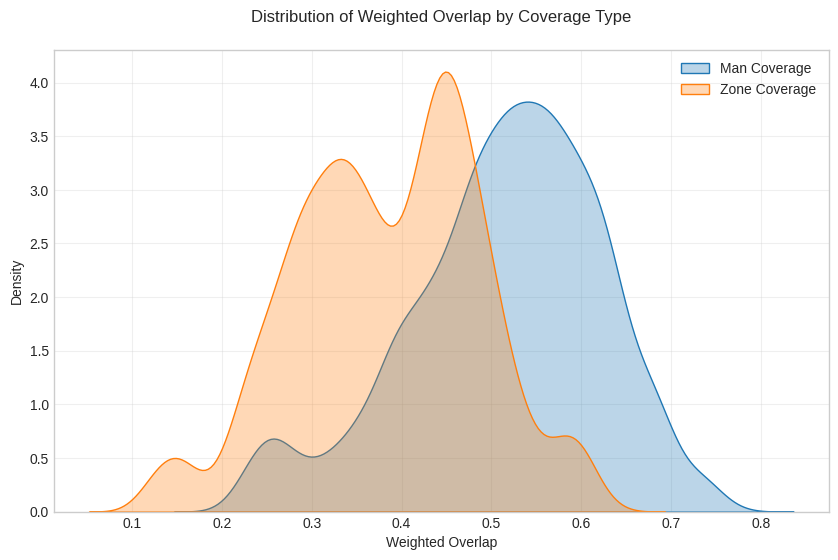

In [ ]:
# For the original weighted_overlap distribution
plot_overlap_distribution(overlap_df)

Next, let's look at the change in overlap of each subsequent frame.

In [ ]:
# Calculate both directional and absolute changes
overlap_changes = (
    overlap_df
    .sort(['gameId', 'playId', 'frameId'])  # Ensure proper ordering
    .group_by(['gameId', 'playId', 'pff_manZone'])
    .agg([
        # Original directional change
        pl.col('weighted_overlap').diff().alias('overlap_delta'),
        # Absolute change
        pl.col('weighted_overlap').diff().abs().alias('absolute_overlap_delta'),
        # Get std dev of both
        pl.col('weighted_overlap').diff().std().alias('directional_volatility'),
        pl.col('weighted_overlap').diff().abs().std().alias('absolute_volatility')
    ])
)

overlap_changes.head()

gameId,playId,pff_manZone,overlap_delta,absolute_overlap_delta,directional_volatility,absolute_volatility
i64,i64,str,list[f64],list[f64],f64,f64
2022090800,3674,"""Zone""","[null, -0.007704, … -0.000379]","[null, 0.007704, … 0.000379]",0.020666,0.01275
2022091806,1189,"""Zone""","[null, 0.01577, … 0.006648]","[null, 0.01577, … 0.006648]",0.017586,0.01073
2022091806,2211,"""Zone""","[null, 0.015539, … 0.006768]","[null, 0.015539, … 0.006768]",0.016952,0.011025
2022100211,2925,"""Zone""","[null, 0.00466, … 0.015417]","[null, 0.00466, … 0.015417]",0.015788,0.010157
2022091102,1700,"""Zone""","[null, -0.016062, … 0.008634]","[null, 0.016062, … 0.008634]",0.019113,0.009048


Then, let's check the distributions of the changes.

In [ ]:
def plot_changes_distribution(overlap_changes, column_name="absolute_volatility", handle_lists=False):
    """
    Plot the distribution of change/volatility metrics for Man and Zone coverage.
    For use with the overlap_changes dataframe.

    Parameters:
    overlap_changes (polars.DataFrame): DataFrame containing coverage change metrics
    column_name (str): Name of the column to plot
    handle_lists (bool): Whether to handle list-type columns with potential null values
    """
    # Handle list-type columns if specified
    if handle_lists:
        # Explode the list column and handle nulls
        man_data = (overlap_changes
                   .filter(pl.col("pff_manZone") == "Man")
                   .select(pl.col(column_name))
                   .explode(column_name)
                   .drop_nulls()
                   .to_pandas())

        zone_data = (overlap_changes
                    .filter(pl.col("pff_manZone") == "Zone")
                    .select(pl.col(column_name))
                    .explode(column_name)
                    .drop_nulls()
                    .to_pandas())
    else:
        # Regular columns
        man_data = (overlap_changes
                   .filter(pl.col("pff_manZone") == "Man")
                   .select(pl.col(column_name))
                   .drop_nulls()
                   .to_pandas())

        zone_data = (overlap_changes
                    .filter(pl.col("pff_manZone") == "Zone")
                    .select(pl.col(column_name))
                    .drop_nulls()
                    .to_pandas())

    # Set the style
    plt.style.use('seaborn-v0_8-whitegrid')

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot both distributions using kernel density estimation
    sns.kdeplot(data=man_data[column_name], label="Man Coverage", fill=True, alpha=0.3)
    sns.kdeplot(data=zone_data[column_name], label="Zone Coverage", fill=True, alpha=0.3)

    # Customize the plot
    title_map = {
        "overlap_delta": "Change in Overlap",
        "absolute_overlap_delta": "Absolute Change in Overlap",
        "directional_volatility": "Directional Volatility",
        "absolute_volatility": "Absolute Volatility"
    }

    plot_title = title_map.get(column_name, column_name.replace('_', ' ').title())
    plt.title(f"Distribution of {plot_title} by Coverage Type", pad=20)
    plt.xlabel(plot_title)
    plt.ylabel("Density")
    plt.legend()

    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Show the plot
    plt.show()

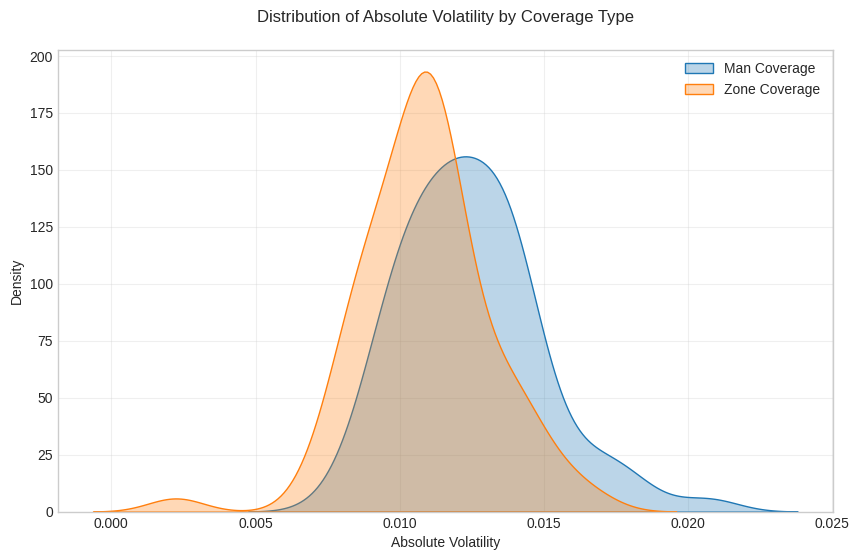

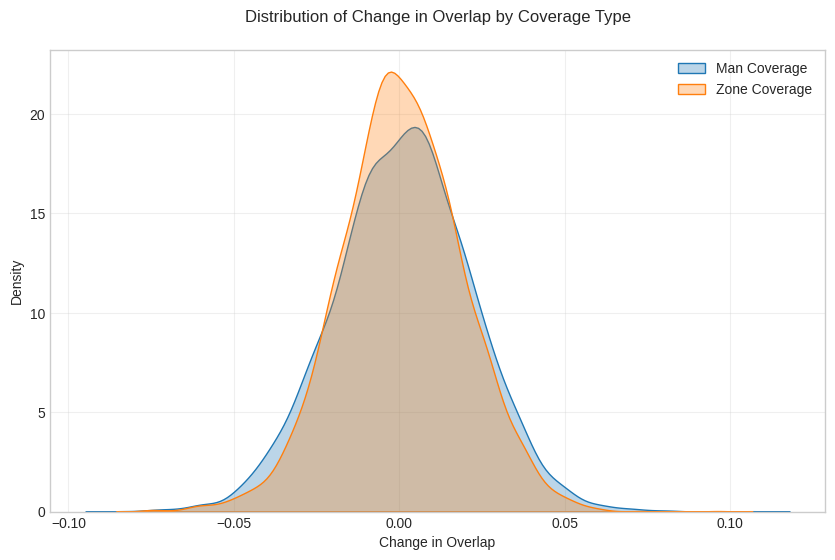

In [ ]:
# For change metrics
plot_changes_distribution(overlap_changes, "absolute_volatility")  # For regular columns
plot_changes_distribution(overlap_changes, "overlap_delta", handle_lists=True)  # For list columns

In [ ]:
def plot_volatility_distributions(overlap_changes):
    """
    Plot regular and log-transformed volatility distributions side by side.
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Get data
    man_data = overlap_changes.filter(pl.col("pff_manZone") == "Man")["absolute_volatility"].to_numpy()
    zone_data = overlap_changes.filter(pl.col("pff_manZone") == "Zone")["absolute_volatility"].to_numpy()

    # Plot regular distribution
    sns.kdeplot(data=man_data, label="Man Coverage", ax=ax1, fill=True, alpha=0.3)
    sns.kdeplot(data=zone_data, label="Zone Coverage", ax=ax1, fill=True, alpha=0.3)
    ax1.set_title("Distribution of Absolute Volatility")
    ax1.set_xlabel("Absolute Volatility")
    ax1.set_ylabel("Density")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot log-transformed distribution
    sns.kdeplot(data=np.log(man_data), label="Man Coverage", ax=ax2, fill=True, alpha=0.3)
    sns.kdeplot(data=np.log(zone_data), label="Zone Coverage", ax=ax2, fill=True, alpha=0.3)
    ax2.set_title("Distribution of Log Absolute Volatility")
    ax2.set_xlabel("Log Absolute Volatility")
    ax2.set_ylabel("Density")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

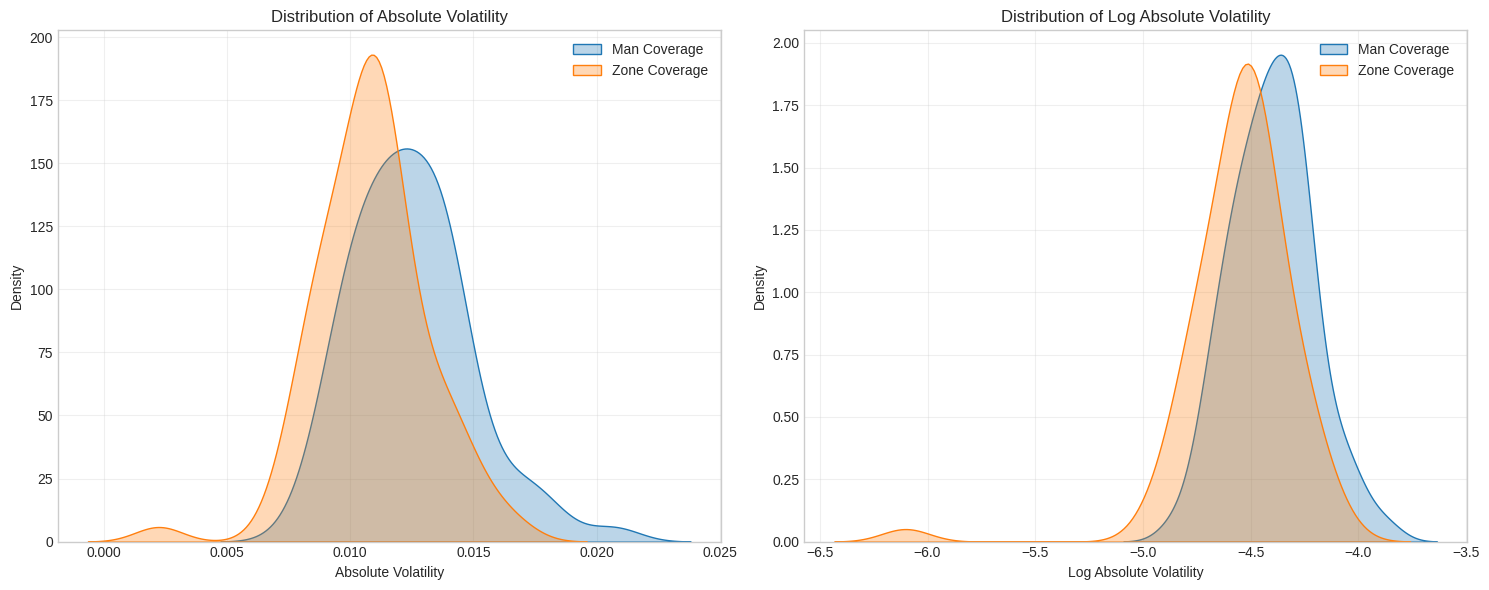

In [ ]:
plot_volatility_distributions(overlap_changes)

To determine if there is a reasonable difference between the two Defense types, we will resort to Bayesian methods.

# Bayesian Volatility Analysis Model

## Bayesian Volatility Analysis Model

For coverage type $i \in \{\text{Man}, \text{Zone}\}$:

### Prior Distributions
$\mu_{\text{Man}} \sim \mathcal{N}(-4.5, 1)$

$\sigma_{\text{Man}} \sim \text{HalfNormal}(0.5)$

$\mu_{\text{Zone}} \sim \mathcal{N}(-4.5, 1)$

$\sigma_{\text{Zone}} \sim \text{HalfNormal}(0.5)$

### Likelihood
$\log(\text{Volatility}_{\text{Man}}) \sim \mathcal{N}(\mu_{\text{Man}}, \sigma_{\text{Man}})$

$\log(\text{Volatility}_{\text{Zone}}) \sim \mathcal{N}(\mu_{\text{Zone}}, \sigma_{\text{Zone}})$

### Derived Quantities
$\text{Mean}_{\text{Man}} = \exp(\mu_{\text{Man}})$

$\text{Mean}_{\text{Zone}} = \exp(\mu_{\text{Zone}})$

$\text{Difference} = \text{Mean}_{\text{Man}} - \text{Mean}_{\text{Zone}}$

Output()


Probability that Man coverage has higher volatility: 1.0

Summary of posterior distributions:
             mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
man_mean    0.012  0.0   0.012    0.013        0.0      0.0   11875.0   
zone_mean   0.011  0.0   0.010    0.011        0.0      0.0   14092.0   
difference  0.002  0.0   0.001    0.003        0.0      0.0   13176.0   

            ess_tail  r_hat  
man_mean      6482.0    1.0  
zone_mean     6307.0    1.0  
difference    6819.0    1.0  


array([[<Axes: title={'center': 'man_mean'}>,
        <Axes: title={'center': 'man_mean'}>],
       [<Axes: title={'center': 'zone_mean'}>,
        <Axes: title={'center': 'zone_mean'}>],
       [<Axes: title={'center': 'difference'}>,
        <Axes: title={'center': 'difference'}>]], dtype=object)

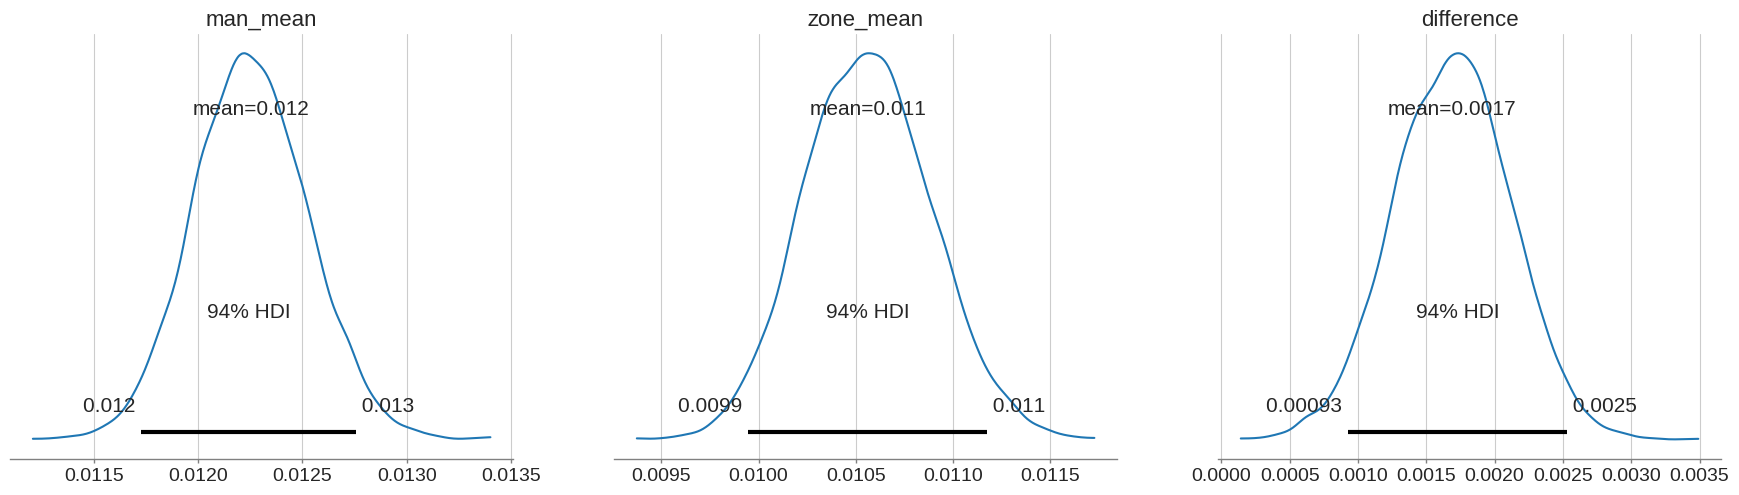

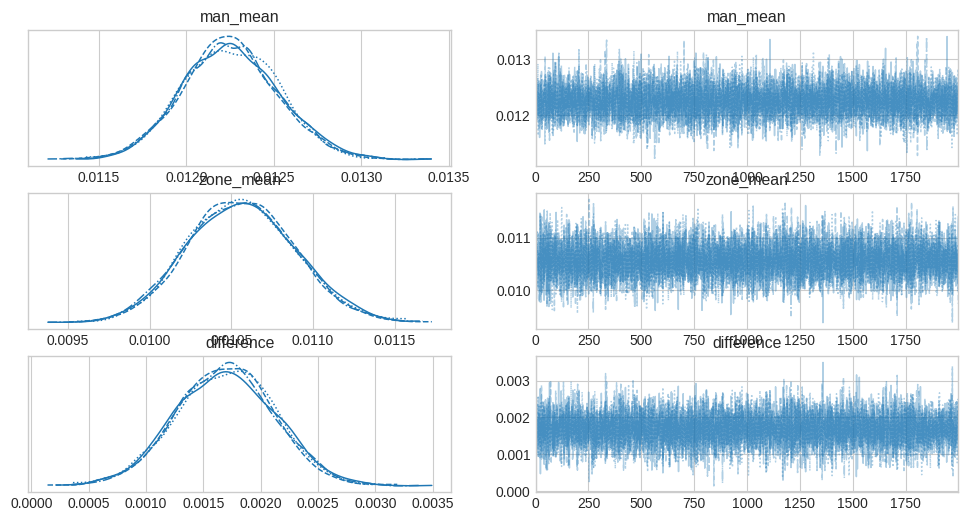

In [ ]:
# First, let's prepare our data
man_volatility = overlap_changes.filter(pl.col('pff_manZone') == 'Man')['absolute_volatility'].to_numpy()
zone_volatility = overlap_changes.filter(pl.col('pff_manZone') == 'Zone')['absolute_volatility'].to_numpy()

# Create and fit Bayesian model
with pm.Model() as volatility_model:

    # Take log of data
    log_man_volatility = np.log(man_volatility)
    log_zone_volatility = np.log(zone_volatility)

    # Parameters for each coverage type
    man_mu = pm.Normal('man_mu', mu=-4.5, sigma=1)
    man_sigma = pm.HalfNormal('man_sigma', sigma=0.5)

    zone_mu = pm.Normal('zone_mu', mu=-4.5, sigma=1)
    zone_sigma = pm.HalfNormal('zone_sigma', sigma=0.5)

    # Likelihood using Normal distribution
    man_likelihood = pm.Normal('man', mu=man_mu, sigma=man_sigma,
                             observed=log_man_volatility)
    zone_likelihood = pm.Normal('zone', mu=zone_mu, sigma=zone_sigma,
                              observed=log_zone_volatility)

    # Transform back to original scale if needed
    man_mean = pm.Deterministic('man_mean', pm.math.exp(man_mu))
    zone_mean = pm.Deterministic('zone_mean', pm.math.exp(zone_mu))

    difference = pm.Deterministic('difference', man_mean - zone_mean)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Calculate probability that Man coverage has higher volatility
prob_man_higher = (trace.posterior['difference'] > 0).mean().item()

# Get summary statistics
summary = az.summary(trace, var_names=['man_mean', 'zone_mean', 'difference'])

print("\nProbability that Man coverage has higher volatility:", prob_man_higher)
print("\nSummary of posterior distributions:")
print(summary)

# Plot posterior distributions
az.plot_posterior(trace, var_names=['man_mean', 'zone_mean', 'difference'])

# Add trace plot
az.plot_trace(trace, var_names=['man_mean', 'zone_mean', 'difference'])

# Bayesian Delta Analysis Model

## Bayesian Delta Analysis Model

### Prior Distributions
$\sigma_{\text{Man}} \sim \text{HalfNormal}(0.1)$

$\sigma_{\text{Zone}} \sim \text{HalfNormal}(0.1)$

$\mu_{\text{Man}} \sim \mathcal{N}(0, 0.1)$

$\mu_{\text{Zone}} \sim \mathcal{N}(0, 0.1)$

### Likelihood
$\Delta_{\text{Man}} \sim \mathcal{N}(\mu_{\text{Man}}, \sigma_{\text{Man}})$

$\Delta_{\text{Zone}} \sim \mathcal{N}(\mu_{\text{Zone}}, \sigma_{\text{Zone}})$

### Derived Quantity
$\text{Difference} = \mu_{\text{Man}} - \mu_{\text{Zone}}$

Output()


Probability that Zone coverage has more negative deltas: 0.904875

Summary of posterior distributions:
             mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
man_mean    0.001  0.0   0.001    0.002        0.0      0.0   13848.0   
zone_mean   0.001  0.0   0.000    0.001        0.0      0.0   13078.0   
difference  0.001  0.0  -0.000    0.001        0.0      0.0   14001.0   

            ess_tail  r_hat  
man_mean      6693.0    1.0  
zone_mean     6998.0    1.0  
difference    6810.0    1.0  


array([[<Axes: title={'center': 'man_mean'}>,
        <Axes: title={'center': 'man_mean'}>],
       [<Axes: title={'center': 'zone_mean'}>,
        <Axes: title={'center': 'zone_mean'}>],
       [<Axes: title={'center': 'difference'}>,
        <Axes: title={'center': 'difference'}>]], dtype=object)

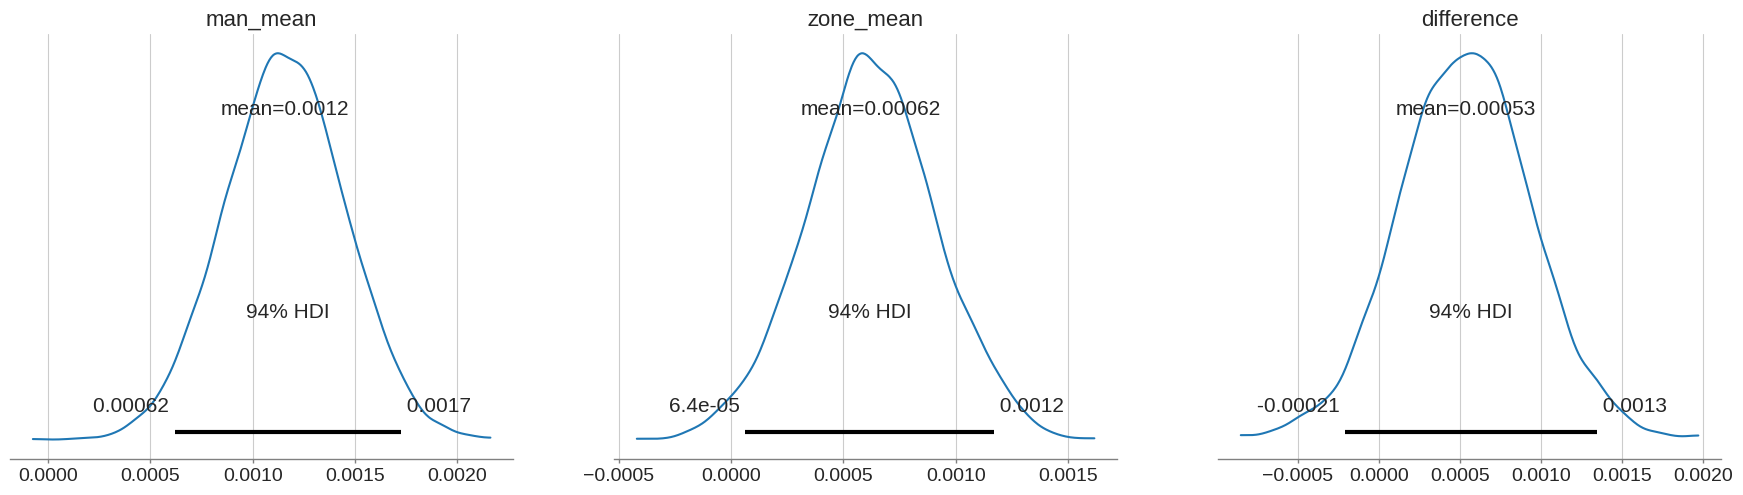

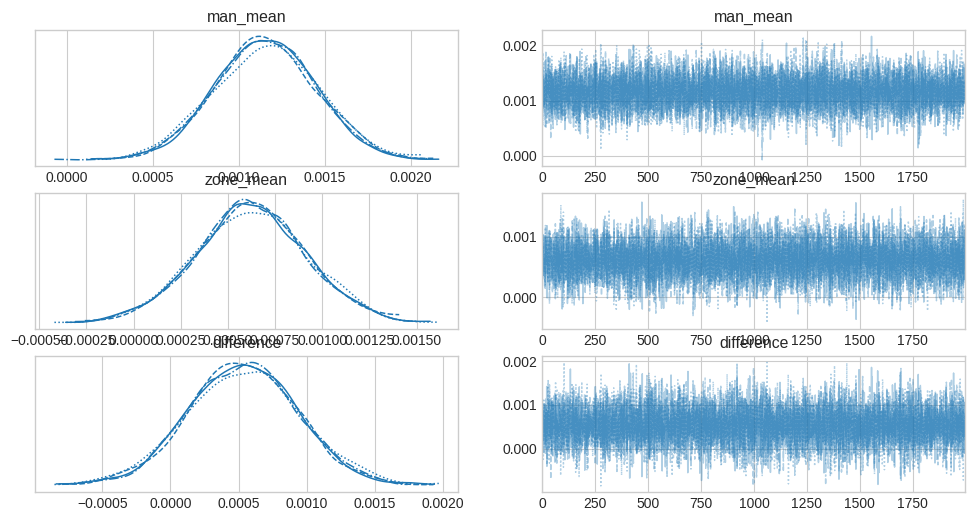

In [ ]:
# Prepare the data by flattening the lists of deltas
man_deltas = []
zone_deltas = []

# Extract and flatten the delta lists for each coverage type
for row in overlap_changes.iter_rows():
    # Get pff_manZone and overlap_delta values
    coverage = row[overlap_changes.columns.index('pff_manZone')]
    deltas = row[overlap_changes.columns.index('overlap_delta')]

    # Remove the null value (first frame) and extend the appropriate list
    deltas_clean = [d for d in deltas if d is not None]
    if coverage == 'Man':
        man_deltas.extend(deltas_clean)
    else:  # Zone
        zone_deltas.extend(deltas_clean)

# Convert to numpy arrays
man_delta = np.array(man_deltas)
zone_delta = np.array(zone_deltas)

# Create and fit Bayesian model
with pm.Model() as delta_model:
    # Priors for each coverage type
    # Using normal distribution since delta can be positive or negative
    man_std = pm.HalfNormal('man_std', sigma=0.1)
    zone_std = pm.HalfNormal('zone_std', sigma=0.1)

    # Mean delta for each coverage type
    # Using wider prior since we don't know the direction of effect
    man_mean = pm.Normal('man_mean', mu=0, sigma=0.1)
    zone_mean = pm.Normal('zone_mean', mu=0, sigma=0.1)

    # Likelihood for each coverage type
    man_likelihood = pm.Normal('man', mu=man_mean, sigma=man_std, observed=man_delta)
    zone_likelihood = pm.Normal('zone', mu=zone_mean, sigma=zone_std, observed=zone_delta)

    # Calculate the difference between coverages (Man - Zone)
    # Positive difference means Man has larger (less negative) deltas
    difference = pm.Deterministic('difference', man_mean - zone_mean)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Calculate probability that Zone has more negative deltas
prob_zone_more_negative = (trace.posterior['difference'] > 0).mean().item()

# Get summary statistics
summary = az.summary(trace, var_names=['man_mean', 'zone_mean', 'difference'])

print("\nProbability that Zone coverage has more negative deltas:", prob_zone_more_negative)
print("\nSummary of posterior distributions:")
print(summary)

# Plot posterior distributions
az.plot_posterior(trace, var_names=['man_mean', 'zone_mean', 'difference'])

# Add trace plot
az.plot_trace(trace, var_names=['man_mean', 'zone_mean', 'difference'])

In order to find certain plays reacting to Defensive coverage, then use the code below.

In [ ]:
def filter_and_sort_overlaps(df: pl.DataFrame,
                           coverage_type: str,
                           sort_col: str,
                           ascending: bool = True,
                           n_rows: int = 3) -> pl.DataFrame:
    """
    Filter overlap data by coverage type and sort by specified column.

    Args:
        df: Input DataFrame
        coverage_type: Either "Man" or "Zone"
        sort_col: Column name to sort by
        ascending: Sort order
        n_rows: Number of rows to return

    Returns:
        Filtered and sorted DataFrame
    """
    filtered = df.filter(pl.col('pff_manZone') == coverage_type)

    if ascending:
        return filtered.sort(sort_col).head(n_rows)
    else:
        return filtered.sort(sort_col, descending=True).head(n_rows)

def calculate_total_delta(df: pl.DataFrame,
                         coverage_type: Optional[str] = None,
                         ascending: bool = True) -> pl.DataFrame:
    """
    Calculate total delta for overlap values per gameId and playId, optionally filtering by coverage type.

    Args:
        df: Input DataFrame
        coverage_type: Optional filter for "Man" or "Zone"
        ascending: Sort order for total_delta

    Returns:
        DataFrame with total_delta column calculated per gameId and playId
    """
    result = df

    if coverage_type:
        result = result.filter(pl.col('pff_manZone') == coverage_type)

    result = result.with_columns([
        pl.col('overlap_delta')
        .explode()
        .drop_nulls()
        .sum()
        .over(['gameId', 'playId'])
        .alias('total_delta')
    ])

    return result.sort('total_delta', descending=not ascending)

# Create filtered dataframes for Man and Zone coverage
# Sorted by absolute_volatility descending
man_volatile_desc = filter_and_sort_overlaps(overlap_changes,
                                           'Man',
                                           'absolute_volatility',
                                           ascending=False)
zone_volatile_desc = filter_and_sort_overlaps(overlap_changes,
                                            'Zone',
                                            'absolute_volatility',
                                            ascending=False)

# Sorted by absolute_volatility ascending
man_volatile_asc = filter_and_sort_overlaps(overlap_changes,
                                          'Man',
                                          'absolute_volatility',
                                          ascending=True)
zone_volatile_asc = filter_and_sort_overlaps(overlap_changes,
                                           'Zone',
                                           'absolute_volatility',
                                           ascending=True)

# Create dataframes with total_delta calculations
man_delta_desc = calculate_total_delta(overlap_changes, 'Man', ascending=False)
man_delta_asc = calculate_total_delta(overlap_changes, 'Man', ascending=True)
zone_delta_desc = calculate_total_delta(overlap_changes, 'Zone', ascending=False)
zone_delta_asc = calculate_total_delta(overlap_changes, 'Zone', ascending=True)

In [ ]:
print("Man Coverage - Most Volatile:")
print(man_volatile_desc)
print("\nZone Coverage - Most Volatile:")
print(zone_volatile_desc)
print("\nMan Coverage - Least Volatile:")
print(man_volatile_asc)
print("\nZone Coverage - Least Volatile:")
print(zone_volatile_asc)
print("\nMan Coverage - Highest Total Delta:")
print(man_delta_desc)
print("\nMan Coverage - Lowest Total Delta:")
print(man_delta_asc)
print("\nZone Coverage - Highest Total Delta:")
print(zone_delta_desc)
print("\nZone Coverage - Lowest Total Delta:")
print(zone_delta_asc)

Man Coverage - Most Volatile:
shape: (3, 7)
┌────────────┬────────┬─────────────┬───────────────┬───────────────┬───────────────┬──────────────┐
│ gameId     ┆ playId ┆ pff_manZone ┆ overlap_delta ┆ absolute_over ┆ directional_v ┆ absolute_vol │
│ ---        ┆ ---    ┆ ---         ┆ ---           ┆ lap_delta     ┆ olatility     ┆ atility      │
│ i64        ┆ i64    ┆ str         ┆ list[f64]     ┆ ---           ┆ ---           ┆ ---          │
│            ┆        ┆             ┆               ┆ list[f64]     ┆ f64           ┆ f64          │
╞════════════╪════════╪═════════════╪═══════════════╪═══════════════╪═══════════════╪══════════════╡
│ 2022091110 ┆ 2869   ┆ Man         ┆ [null,        ┆ [null,        ┆ 0.033378      ┆ 0.020716     │
│            ┆        ┆             ┆ 0.017993, …   ┆ 0.017993, …   ┆               ┆              │
│            ┆        ┆             ┆ 0.026574]     ┆ 0.026574]     ┆               ┆              │
│ 2022101601 ┆ 2216   ┆ Man         ┆ [null,   